In [23]:
### If You do not have one of these packages, you can simply run: !pip install <package>

# You may also find this video helpful for permanent installations (basically installs folder to your drive)
# >> https://www.youtube.com/watch?v=ErwLcnvhW4A&t=473s

# You may also find this paper helpful for some intro information / description of optimizer algorithms
# >> https://arxiv.org/pdf/1803.08823

import torch
from fastai.tabular.all import *
from tqdm import tqdm

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [ ]:
import torch
from fastai.tabular.all import *
from tqdm import tqdm

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [11]:
import sympy as sym
from scipy.integrate import quad
from scipy.integrate import cumulative_trapezoid

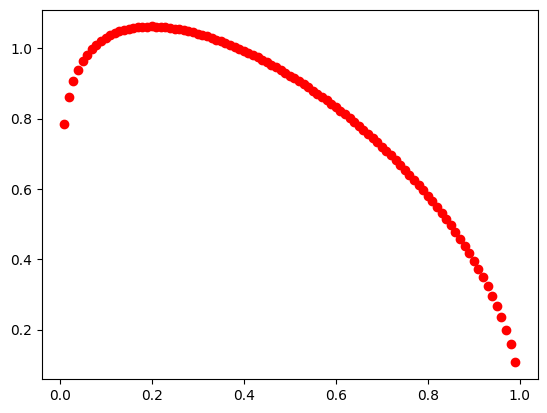

In [183]:
### Toy Model Parton Distribution Function

x = torch.arange(1,100).float()/100.

def h(x, params):

  N,a,b = params

  return N*x**a*(1-x)**b

def show(preds, ax=None):
    if ax is None:
        ax = plt.subplots()[1]
    # ax.scatter(time, signal)
    ax.scatter(x, to_np(preds), color="red")
    plt.show()

sig_params = torch.abs(torch.randn(3)).requires_grad_()
# sig_params
signal = h(x, sig_params)
show(signal)

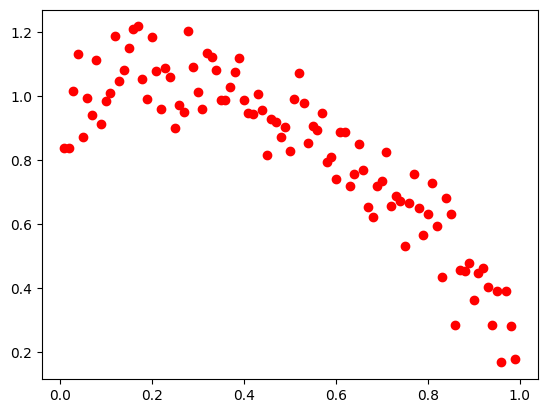

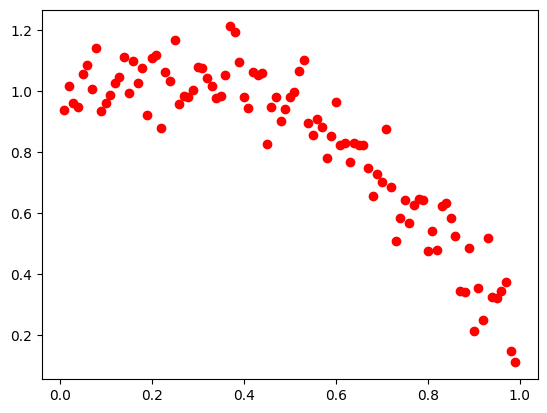

In [184]:
### Generate Data w/ Noise

# If we perform a fit with different pieces of noisey data to generate an uncertainty band \n
# This is known as the replica method (or monte carlo method) for generating uncertainty

N_train = 100
max_sig = max(signal.data)
min_sig = min(signal.data)
noise_amp = 0.1*(max_sig - min_sig)
X_train = []

for i in range(N_train):
  noise = torch.randn_like(signal)*noise_amp
  sample = signal + noise
  X_train.append(sample)

show(X_train[0])
show(X_train[30])

In [185]:
### Loss Functions

# Loss per sample
def mserr(preds, targets):
    return ((preds - targets) ** 2).mean()

# Loss per round of training (So takes in entire trainging set)
def batch_loss(preds):

  temp_loss = 0
  for i in range(N_train):

    temp_loss += mserr(preds, X_train[i])

  temp_loss /= N_train #average loss

  return temp_loss

In [8]:
# I like to seperate different parts of the code w/ empty cells.

In [9]:
##### DNN Regression

In [226]:
##### Define Model for Collinear Modulation

### NN = NN(x, q_type); q_type is quark type (modulate pdf for each quark type to prouce g_1T)
### For moderate x, restrict to just valence (up and down)

### Need to normalize to N >> But N is a parameter? I guess just choose N = 1

### NN Definition

class MLPcondensed(nn.Module):
    '''
    Multi-layer perceptron for non-linear regression.
    '''
    def __init__(self, nInput, nHidden, nOutput):
        super().__init__()
        self.layers = nn.Sequential(
            # Specify layers, followed by activation for that layer
            # What if you want different activations for different nodes?
            # When would that ^ be desireable?
            nn.Linear(nInput, nHidden),
            #nn.Sigmoid(),
            #nn.LeakyReLU(),
            #nn.ReLU(),
            #nn.Tanh(),
            nn.Softplus(),
            nn.Linear(nHidden, nHidden),
            #nn.Sigmoid(),
            #nn.LeakyReLU(),
            #nn.ReLU(),
            #nn.Tanh(),
            nn.Softplus(),
            nn.Linear(nHidden, nHidden),
            #nn.Sigmoid(),
            #nn.LeakyReLU(),
            #nn.ReLU(),
            #nn.Tanh(),
            nn.Softplus(),
            nn.Linear(nHidden, nOutput)
        )

    def forward(self, x):
        return(self.layers(x))

    # def forward(self, zL, zh, hadron, lambda_bar):
    #     return(self.layers(zL, zh, hadron, lambda_bar))

### 2 input x, q_type
mlpCondensed = MLPcondensed(1,3,1)
DNN_model_1 = mlpCondensed

In [227]:
### Loss Function

def mse_f(preds, targets):

    # preds = model(x)

    return ((preds - targets) ** 2).mean()

def batch_loss(preds):

    loss = 0

    for n in range(N_train):

        targets = X_train[n]
        loss += ((preds - targets) ** 2).mean()

    return loss / N_train

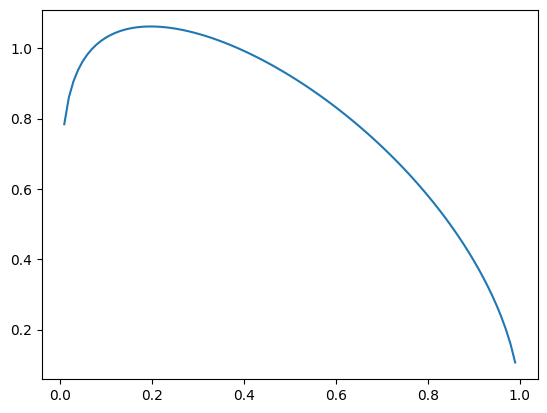

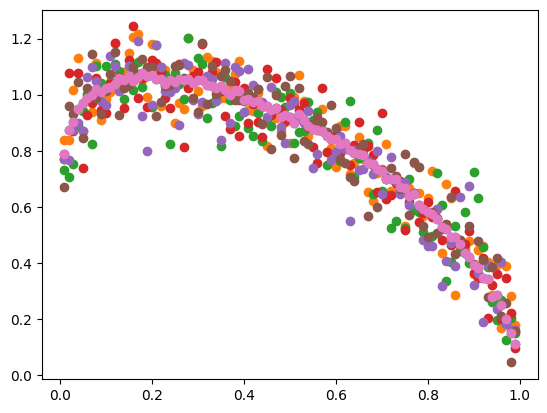

In [228]:
### Plot Central Values

# Just to see how the average data (the true function, if you like) compares across the entire set

plt.figure(0)
plt.plot(x.data, h(x, sig_params).data)


### Plot scattered central values

plt.figure(1)

avg_rep = torch.zeros(len(x))

for n in range(N_train):

    avg_rep += X_train[n]

avg_rep /= N_train

plt.scatter(x.data, avg_rep.data)
for i in range(5): plt.scatter(x.data, X_train[i].data)

plt.scatter(x.data, avg_rep.data)

In [229]:
# This is necessary for DNN_model_1 to serve as an input to our model

x_input = torch.reshape(x, (len(x), 1))

# Ex:
DNN_model_1(x_input).squeeze()

tensor([-0.7304, -0.7305, -0.7305, -0.7305, -0.7306, -0.7306, -0.7306, -0.7307,
        -0.7307, -0.7307, -0.7308, -0.7308, -0.7308, -0.7309, -0.7309, -0.7309,
        -0.7310, -0.7310, -0.7310, -0.7311, -0.7311, -0.7311, -0.7312, -0.7312,
        -0.7312, -0.7313, -0.7313, -0.7313, -0.7314, -0.7314, -0.7314, -0.7315,
        -0.7315, -0.7316, -0.7316, -0.7316, -0.7317, -0.7317, -0.7317, -0.7318,
        -0.7318, -0.7318, -0.7319, -0.7319, -0.7320, -0.7320, -0.7320, -0.7321,
        -0.7321, -0.7321, -0.7322, -0.7322, -0.7323, -0.7323, -0.7323, -0.7324,
        -0.7324, -0.7325, -0.7325, -0.7325, -0.7326, -0.7326, -0.7327, -0.7327,
        -0.7327, -0.7328, -0.7328, -0.7329, -0.7329, -0.7329, -0.7330, -0.7330,
        -0.7331, -0.7331, -0.7331, -0.7332, -0.7332, -0.7333, -0.7333, -0.7334,
        -0.7334, -0.7334, -0.7335, -0.7335, -0.7336, -0.7336, -0.7337, -0.7337,
        -0.7337, -0.7338, -0.7338, -0.7339, -0.7339, -0.7340, -0.7340, -0.7341,
        -0.7341, -0.7341, -0.7342], grad

In [230]:
### Organize data into batches
xObs = x
yObs = X_train[0]

for i in range(1, len(X_train)):

    xObs = torch.cat((xObs, x))
    yObs = torch.cat((yObs, X_train[i]))

In [231]:
### Organize Training Data

### They want to use Dataloaders in batches of 25 training points
### Apparently networks learn better this way

class nonLinearRegressionData(Dataset): #Dataset comes with some nice methods
    '''
    Custom 'Dataset' object for our regression data.
    Must implement these functions: __init__, __len__, and __getitem__.
    '''

    def __init__(self, xObs, yObs):

        # Reshape I think because need them to be matrices for network input
        self.xObs = torch.reshape(xObs, (len(xObs), 1))
        self.yObs = torch.reshape(yObs, (len(yObs), 1))

    def __len__(self):
        return(len(self.xObs))

    def __getitem__(self, idx):
        return(xObs[idx], yObs[idx])

# instantiate Dataset object for current training data
d = nonLinearRegressionData(xObs, yObs)

print(d)

train_dataloader = DataLoader(d, batch_size=10 , shuffle=True)

In [16]:
##### Train

In [232]:
### Train
from tqdm import tqdm

# Define the loss function and optimizer
mlpCondensed = MLPcondensed(1,10,1)
DNN_model = mlpCondensed
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(DNN_model.parameters(), lr=1e-2)
nTrainSteps = 30
#nTrainSteps = 60

def training():
  # Track loss over epochs
  track_loss = np.zeros(nTrainSteps)

  # Run the training loop
  for epoch in tqdm(range(0, nTrainSteps)):

    # Iterate over the DataLoader for training data
    for i, data in enumerate(train_dataloader, 0):

      # Get inputs
      inputs, targets = data

      # Zero the gradients
      optimizer.zero_grad()

      # Perform forward pass (make sure to supply the input in the right way)
      outputs = DNN_model(torch.reshape(inputs, (len(inputs), 1))).squeeze()

      # Compute loss
      loss = loss_function(outputs, targets)

      # Perform backward pass
      loss.backward(retain_graph = True)

      # Perform optimization
      optimizer.step()

      track_loss[epoch] = loss.item()

  return track_loss

# Process is complete.
print('Training process has finished.')

Training process has finished.


100%|██████████| 30/30 [00:45<00:00,  1.52s/it]


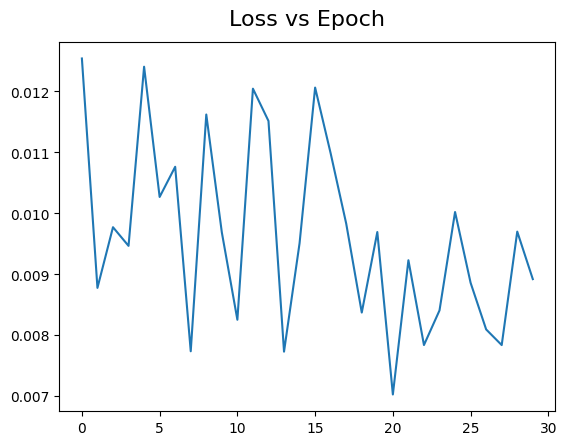

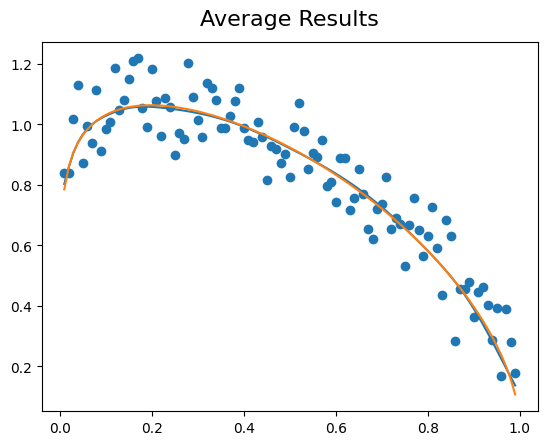

In [233]:
done_losses = {} #dictionary
gotten_results = {}
numIters = 10
for i in range(0,numIters):
  results_of_iteration = training() #gets current array
  #print(results_of_iteration)
  for j in range(0,nTrainSteps):
    if j in done_losses:
      done_losses[j] += results_of_iteration[j]
    else:
      done_losses[j] = results_of_iteration[j]
  gotten_results[i] = DNN_model(x_input).squeeze().data

average_losses = [0]*nTrainSteps
for i in range(0,nTrainSteps):
  average_losses[i] = done_losses[i]/numIters

avg_results = [0]*len(gotten_results[0])
for i in range(0,numIters):
  for j in range(0,len(gotten_results[i])):
      avg_results[j] += gotten_results[i][j]
  #print(avg_results)
for i in range(0,len(avg_results)):
  avg_results[i] /= numIters

# print("average losses ", average_losses)
plt.figure(0)
plt.title("Loss vs Epoch", fontsize = 16, pad = 12)
plt.plot(np.arange(nTrainSteps), average_losses)

plt.figure()
plt.title("Average Results", fontsize = 16, pad = 12)
plt.plot(x.data, avg_results, label = 'Average Fit')
plt.plot(x.data, h(x, sig_params).data, label = 'True PDF')
plt.scatter(x.data, X_train[0].data)

In [ ]:
### I find it useful to plot how the loss evolves during training

# This can tell you if we plateau rapidly, etc

plt.figure(0)
plt.title("Loss vs Epoch", fontsize = 16, pad = 12)
plt.plot(np.arange(nTrainSteps), track_loss)

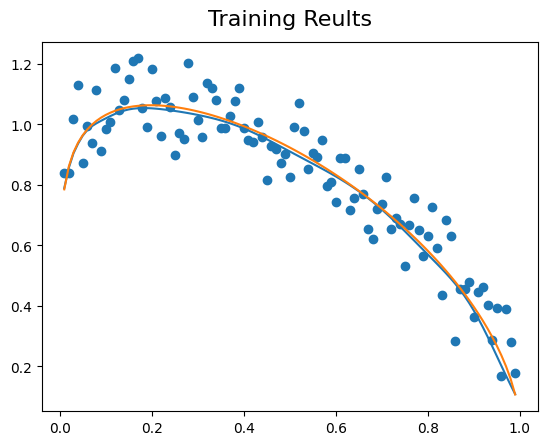

In [234]:
### Plot model results, true signal, and noisey data point

plt.figure()
plt.title("Training Reults", fontsize = 16, pad = 12)
plt.plot(x.data, DNN_model(x_input).squeeze().data, label = 'DNN Fit')
plt.plot(x.data, h(x, sig_params).data, label = 'True PDF')
plt.scatter(x.data, X_train[0].data)